In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Exercise%20-%20Answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [3]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2020-05-13 13:39:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4009:802::2010, 172.217.9.80
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4009:802::2010|:443... connected.
HTTP request sent, awaiting response...200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  7.90MB/s    in 0.6s    

2020-05-13 13:39:55 (7.90 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [4]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [5]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))
# Expected Output
# 153

153


In [6]:
with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        sentences.append(sentence)

print(len(labels))
print(len(sentences))
print(sentences[0])
# Expected Output
# 2225
# 2225
# tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertainment. us networks cable satellite companies worried means terms advertising revenues well  brand identity  viewer loyalty channels. although us leads technology moment  also concern raised europe  particularly growing uptake services like sky+.  happens today  will see nine months years  time uk   adam hume  bbc broadcast s futurologist told bbc news website. likes bbc  no issues lost advertising revenue yet. pressing issue moment commercial uk broadcasters  brand loyalty important everyone.  will talking content brands rather network brands   said tim hanlon  brand communications firm starcom mediavest.  reality broadband connections  anybody can producer content.  added:  challenge now hard promote programme much choice.   means  said stacey jolna  senior vice president tv guide tv group  way people find content want watch simplified tv viewers. means networks  us terms  channels take leaf google s book search engine future  instead scheduler help people find want watch. kind channel model might work younger ipod generation used taking control gadgets play them. might not suit everyone  panel recognised. older generations comfortable familiar schedules channel brands know getting. perhaps not want much choice put hands  mr hanlon suggested.  end  kids just diapers pushing buttons already - everything possible available   said mr hanlon.  ultimately  consumer will tell market want.   50 000 new gadgets technologies showcased ces  many enhancing tv-watching experience. high-definition tv sets everywhere many new models lcd (liquid crystal display) tvs launched dvr capability built  instead external boxes. one example launched show humax s 26-inch lcd tv 80-hour tivo dvr dvd recorder. one us s biggest satellite tv companies  directtv  even launched branded dvr show 100-hours recording capability  instant replay  search function. set can pause rewind tv 90 hours. microsoft chief bill gates announced pre-show keynote speech partnership tivo  called tivotogo  means people can play recorded programmes windows pcs mobile devices. reflect increasing trend freeing multimedia people can watch want  want.

2225
2225
tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertai

In [7]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

# Expected output (if training_portion=.8)
# 1780
# 1780
# 1780
# 445
# 445

1780
1780
1780
445
445


In [8]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

# Expected Ouput
# 449
# 120
# 200
# 120
# 192
# 120

449
120
200
120
192
120


In [9]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)

# Expected output
# 445
# (445, 120)

445
(445, 120)


In [10]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

# Expected output
# [4]
# [2]
# [1]
# (1780, 1)
# [5]
# [4]
# [3]
# (445, 1)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

# Expected Output
# Layer (type)                 Output Shape              Param #   
# =================================================================
# embedding (Embedding)        (None, 120, 16)           16000     
# _________________________________________________________________
# global_average_pooling1d (Gl (None, 16)                0         
# _________________________________________________________________
# dense (Dense)                (None, 24)                408       
# _________________________________________________________________
# dense_1 (Dense)              (None, 6)                 150       
# =================================================================
# Total params: 16,558
# Trainable params: 16,558
# Non-trainable params: 0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [20]:
num_epochs = 500
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

3
Epoch 299/500
1780/1780 - 0s - loss: 3.8107e-08 - acc: 1.0000 - val_loss: 0.4265 - val_acc: 0.9483
Epoch 300/500
1780/1780 - 0s - loss: 3.7102e-08 - acc: 1.0000 - val_loss: 0.4272 - val_acc: 0.9483
Epoch 301/500
1780/1780 - 0s - loss: 3.6031e-08 - acc: 1.0000 - val_loss: 0.4286 - val_acc: 0.9483
Epoch 302/500
1780/1780 - 0s - loss: 3.5562e-08 - acc: 1.0000 - val_loss: 0.4287 - val_acc: 0.9483
Epoch 303/500
1780/1780 - 0s - loss: 3.4289e-08 - acc: 1.0000 - val_loss: 0.4289 - val_acc: 0.9483
Epoch 304/500
1780/1780 - 0s - loss: 3.4356e-08 - acc: 1.0000 - val_loss: 0.4294 - val_acc: 0.9483
Epoch 305/500
1780/1780 - 0s - loss: 3.3687e-08 - acc: 1.0000 - val_loss: 0.4301 - val_acc: 0.9483
Epoch 306/500
1780/1780 - 0s - loss: 3.2615e-08 - acc: 1.0000 - val_loss: 0.4302 - val_acc: 0.9483
Epoch 307/500
1780/1780 - 0s - loss: 3.2079e-08 - acc: 1.0000 - val_loss: 0.4308 - val_acc: 0.9483
Epoch 308/500
1780/1780 - 0s - loss: 3.1209e-08 - acc: 1.0000 - val_loss: 0.4309 - val_acc: 0.9506
Epoch 30

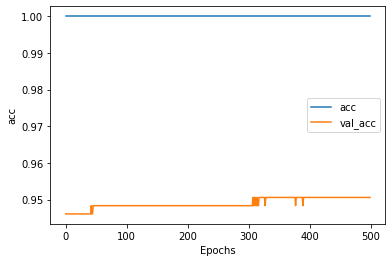

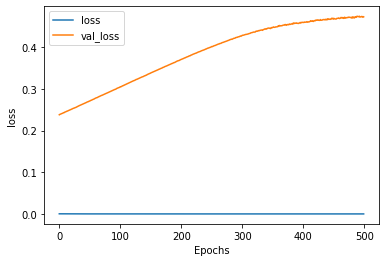

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  

plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [22]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [23]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Expected output
# (1000, 16)

(1000, 16)


In [25]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

# for use in tensorflow vector graphics